# How to optimize a simple 1D function

In this tutorial we will learn, how to optimize a simple noisy 1D test function.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import bask
from bask import Optimizer
plt.style.use('bmh')
colors = plt.cm.get_cmap("Set1").colors

## Specifying the target function
First we start by simulating our 1d target function:

In [6]:
def test_function(x):
    return (1.4 - 3 * x) * np.sin(18 * x)

Here you can set the noise (standard deviation) of the generated data. To keep the execution time of this notebook short, we will set it to $0.1$. You can experiment with setting it to different values:

In [7]:
rand = np.random.RandomState(123)
noise = 1e-1

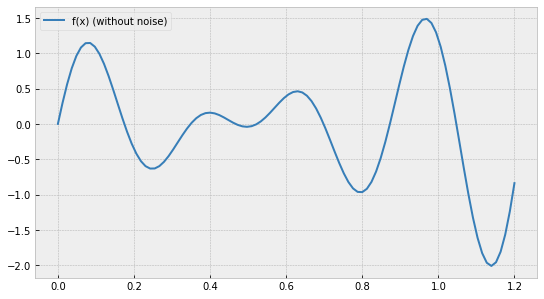

In [8]:
fig, ax = plt.subplots(figsize=(9, 5))
xx = np.linspace(0, 1.2, num=100)
yy = test_function(xx)
ax.plot(xx, yy, color=colors[1], label="f(x) (without noise)")
plt.legend(loc=2);

The target function has four local minima with two being close in value.
We will now see how the optimizer will deal with this problem.

## Using the optimizer
### Specify parameters, kernel and priors
Since we have a 1D target function, we only need to specify one parameter.
Bask expects the parameters to be given as a list:

In [9]:
parameters = [(0., 1.2)]

Now we need to specify the kernel of the Gaussian process.
There are many kernels we can choose from, but a good default choice is the Matérn kernel:

In [10]:
from skopt.learning.gaussian_process.kernels import Matern
from scipy.stats import invgamma, halfnorm
kernel = 1.0 ** 2 + Matern(length_scale=1., length_scale_bounds=(0.1, 2.))

The `1.0 ** 2` implicitly defines a `ConstantKernel` for the signal variance, which defines how much the actual target function varies.
The given bounds restrict the length scale which the initial maximum marginal likelihood estimate can produce.

Since we are in the fully Bayesian setting, we also have to provide priors for the kernel parameters.
Half-normal distributions are a good default choice for the signal variance and signal noise.
For the length scale of the Matérn kernel we go with a slightly informative inverse-gamma distribution.
It constrains the length scale to be in a plausible range of values, while avoiding the non-identifiability issues one typically encounters when fitting Gaussian processes.

In [11]:
priors = [
    # Prior distribution for the signal variance:
    lambda x: halfnorm(scale=2.).logpdf(np.sqrt(np.exp(x))) + x / 2.0 - np.log(2.0),
    # Prior distribution for the length scale:
    lambda x: invgamma(a=8.29, scale=2.46).logpdf(np.exp(x)) + x,
    # Prior distribution for the noise:
    lambda x: halfnorm(scale=0.5).logpdf(np.sqrt(np.exp(x))) + x / 2.0 - np.log(2.0)
]

What is left is to define the actual optimizer:

In [13]:
n_initial_points = 2
opt = Optimizer(
    parameters,
    n_points=20,
    n_initial_points=n_initial_points,
    gp_kernel=kernel,
    gp_kwargs=dict(normalize_y=False),
    gp_priors=priors,
    acq_func="pvrs",
    acq_func_kwargs=dict(n_thompson=3),
    random_state=rand.randint(0, np.iinfo(np.int32).max)
)

It is usually good practice to seed the optimization with a set of initial points. Here we choose 2 (quasi)-random points.
We use "predictive variance reduction search" as the acquisition function here.
It is a very robust acquisition function which quickly converges to the global optimum.

Other available acquisition functions are:

* "ei": Expected improvement
* "ttei": Top-two expected improvement
* "lcb": Lower confidence bound
* "mean": Lowest GP mean
* "mes": Max-value entropy search
* "ts": Thompson sampling
* "vr": Global variance reduction

"pvrs", "mes" and "ts" are recommended, if your goal is to minimize the cumulative regret/simple regret (to quickly find the optimum).
If your goal is to fit the target function as accurately as possible (active learning), then use the "vr" criterion.

To reduce the running time of the optimization, we set `n_points=50` and `n_thompson=3`.

### Run the optimizer
We will now run the optimizer for 32 iterations (2 initial points + 30 using the acquisition function).
In order to be able to plot the iterations, we also record the intermediate model predictions.
Note, that this cell needs a few minutes to run (depending on the parameters you set earlier).

In [14]:
%%time
n_iterations = 30 + n_initial_points
n_grid = 200
xx = np.linspace(0, 1.2, num=n_grid)
predictions = np.empty((n_iterations - n_initial_points, n_grid, 2))
for i in range(n_iterations):
    x = opt.ask()
    y = test_function(x[0]) + rand.randn() * noise
    opt.tell(x, y, n_samples=0, gp_samples=200, gp_burnin=5)
    if i >= n_initial_points:
        with opt.gp.noise_set_to_zero():
            predictions[i-n_initial_points] = np.array(opt.gp.predict(opt.space.transform(xx[:, None].tolist()), return_std=True)).T

CPU times: user 1min 30s, sys: 15.7 s, total: 1min 46s
Wall time: 1min 17s


### Plot the iterations

IndexError: index 5 is out of bounds for axis 0 with size 5

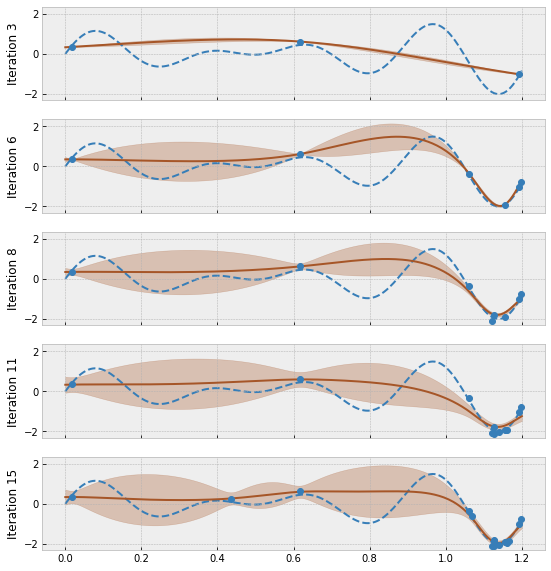

In [16]:
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(9, 10), sharex=True, sharey=True)
it_to_plot = [0, 3,5,8, 12, 19, 29]
for j, i in enumerate(it_to_plot):
    mu, se = predictions[i, :, 0], predictions[i, :, 1]
    axes[j].plot(xx, mu, color=colors[6], zorder=2, label="GP Mean")
    axes[j].fill_between(xx, mu - 1.6 * se, mu + 1.6 * se, alpha=0.3, color=colors[6], zorder=0, label="84% Standard error")
    axes[j].plot(opt.Xi[:i+1 + n_initial_points], opt.yi[:i+1 + n_initial_points], "o", color=colors[1], zorder=5, label="Observations")
    axes[j].plot(xx, test_function(xx), "--", zorder=1, color=colors[1], label="True function")
    axes[j].set_ylabel(f"Iteration {i+n_initial_points+1}")
plt.tight_layout()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=4);

Usually, we are interested in extracting the global optimum of the (mean) Gaussian process.
This we can easily do as follows:

In [17]:
from skopt.utils import expected_minimum, create_result
result_object = create_result(opt.Xi, opt.yi, space=opt.space, models=[opt.gp])
opt_x, opt_y = expected_minimum(result_object)
print(f"Best point found so far: x={np.around(opt_x[0], 4)}, y={np.around(opt_y, 4)}")

Best point found so far: x=1.1409, y=-1.9944
